# HPFRT filtering
For a model evolution equation:

$$ \partial_t u + F(u) = 0 $$

The filtering is equivalent to adding a dissipative term operating following a high-pass filter. This is otherwise termed as a relaxation term:

$$ \partial_t u + F(u) = -\chi H(u) $$

The high pass filter function $H$ is a function operates in the spectral / modal space ($\phi(k)$) containing $N$ modes:

$$H(u_N(x)) = \Sigma_k h(k) a(k) \phi(k, x)$$

where $h(k)$ is described as:

$$
h(k) = \left\{
\begin{array}{ll}
\left( \frac{k-k_c}{N-k_c} \right)^2, & k \gt k_c\\
0,& k \leq k_c \\
\end{array}
\right.
$$

## Implementation in Nek5000

The relevant lines of code are:

* In `core/reader_par.f`

```fortran
call finiparser_getDbl(d_out,'general:filterWeight',ifnd)
if (ifnd .eq. 1) then
  param(103) = d_out 
...
call finiparser_getDbl(d_out,'general:filterCutoffRatio',ifnd)
if (ifnd .eq. 1) then
  dtmp = anint(lx1*(1.0 - d_out)) 
  param(101) = max(dtmp-1,0.0)
...
```
* In `core/hpf.f`

```fortran
hpf_kut = int(param(101))+1
hpf_chi = -1.0*abs(param(103))
...
call ident   (diag,nx)
nx = lx1
...
kut = hpf_kut
k0 = nx-kut
do k=k0+1,nx
  kk = k+nx*(k-1)
  amp = ((k-k0)*(k-k0)+0.)/(kut*kut+0.)     ! Normalized amplitude. quadratic growth
  diag(kk) = 1.-amp
enddo
```

## The transfer function

In [26]:
import numpy as np


def transfer_function(order, cutoff):
    # order = nx = lx1
    k = np.arange(0., order + 1)
    diag = np.ones_like(k)
    
    dtmp = np.round(order * (1 - cutoff))
    # no. of filtered wavenumber modes
    param_101 = max(dtmp - 1, 0.)
    # print("dtmp, param(101):", dtmp, param_101)
    
    kut = int(param_101) + 1
    k0 = order - kut  # cutoff wavenumber
    
    cond = k > k0
    amp = (k - k0)**2 / kut**2 
    diag[cond] = 1. - amp[cond]
    
    return 1 - diag


def weighted_transfer_function(order, cutoff, weight, dt):
    param_103 = weight
    
    transf = transfer_function(order, cutoff)
    return weight * dt * transf

In [27]:
order = 8

transfer_function(order, 0.75)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 1.  ])

In [28]:
weighted_transfer_function(order, 0.75, 0.25, 1)

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0625,
       0.25  ])

# Effects of filtering parameters

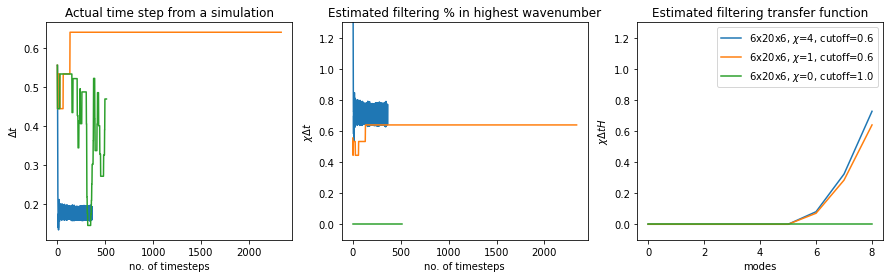

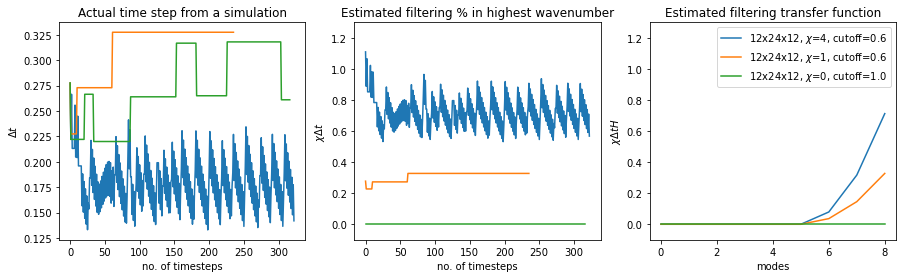

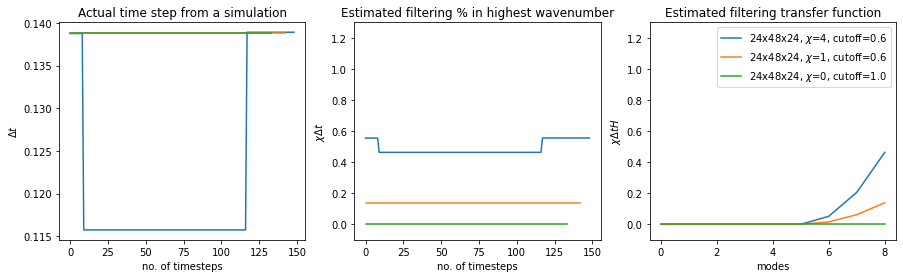

In [30]:
import matplotlib.pyplot as plt
import numpy as np

from eturb.output.print_stdout import PrintStdOut

for w in range(1, 4):
    name = f"run_w{w}"
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ax1, ax2, ax3 = axes.ravel()
    for file in [f"{name}.log", f'{name}_mildfilter.log', f'{name}_nofilter.log']:
        stdout = PrintStdOut(file)
        # print(stdout.path_run)
        params = stdout.params
        fw = params.nek.general.filter_weight
        fc = params.nek.general.filter_cutoff_ratio
        # print(fw, fc)
        label=rf"{params.oper.nx}x{params.oper.ny}x{params.oper.nz}, $\chi$={fw}, cutoff={fc}"
        
        dt_median = np.median(stdout.time_step)
        w_transf = weighted_transfer_function(params.oper.elem.order, fc, fw, dt_median)
        
        ax1.plot(stdout.time_step, label=label)
        # ax1.hlines(dt_median, 0, 500)
        ax2.plot(stdout.time_step * fw, label=label)
        ax3.plot(w_transf, label=label)

        ax1.set_ylabel(r"$\Delta t$")
        ax1.set_xlabel("no. of timesteps")
        ax2.set_ylabel(r"$\chi \Delta t$")
        ax2.set_xlabel("no. of timesteps")
        ax3.set_ylabel(r"$\chi \Delta t H$")
        ax3.set_xlabel("modes")

        ax1.set_title("Actual time step from a simulation")
        ax2.set_title("Estimated filtering % in highest wavenumber")
        ax3.set_title("Estimated filtering transfer function")

        #ax1.legend()
        #ax2.legend()
        ax3.legend()
        ax2.set_ylim(-0.1, 1.3)
        ax3.set_ylim(-0.1, 1.3)
        fig.show()
